In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from scipy.signal import butter, filtfilt, decimate
from obspy.signal.filter import bandpass
import random
import pywt


Read Miniseed files

In [16]:
def read_miniseed_file(file_path):
    

    try:
      st = read(file_path)
      # Print out the keys/attributes of each Trace in the Stream
      for trace in st:
          print(f"Trace ID: {trace.id}")
          print(f"Start Time: {trace.stats.starttime}")
          print(f"End Time: {trace.stats.endtime}")
          print(f"Number of Samples: {trace.stats.npts}")
          print(f"Sampling Rate: {trace.stats.sampling_rate} Hz")
          print(f"Data: {trace.data[:10]}...")  # Print first 10 data points for brevity
          print(f"Keys: {trace.stats.keys()}")
          print('-' * 40)
        
    except Exception as e:
        print(f"An error occurred: {e}")        
def read_miniseed_files(files_directory):

    
    for filename in os.listdir(files_directory):
      if filename.endswith(".mseed"):
          file_path = os.path.join(files_directory, filename)
          try:
            st = read(files_directory)
            # Print out the keys/attributes of each Trace in the Stream
            for trace in st:
                print(f"Trace ID: {trace.id}")
                print(f"Start Time: {trace.stats.starttime}")
                print(f"End Time: {trace.stats.endtime}")
                print(f"Number of Samples: {trace.stats.npts}")
                print(f"Sampling Rate: {trace.stats.sampling_rate} Hz")
                print(f"Data: {trace.data[:10]}...")  # Print first 10 data points for brevity
                print(f"Keys: {trace.stats.keys()}")
                print('-' * 40)
              
          except Exception as e:
              print(f"An error occurred in file {filename}: {e}")        

Convert Amplitude to Velocity

In [55]:
from obspy import read, Stream, Trace
import numpy as np
import os
import matplotlib.pyplot as plt

def Amplitude_to_Velocity_file(file_path, save_velocity=False, plot_amplitude=True, plot_velocity=True, save_plots=False, output_folder=None):
    """
    Convert amplitude to velocity for each trace in a .mseed file, plot amplitude and velocity, and save if required.

    Parameters:
        file_path (str): The absolute path to the .mseed file.
        save_velocity (bool): Whether to save the velocity data as .mseed.
        plot_amplitude (bool): Whether to plot the amplitude.
        plot_velocity (bool): Whether to plot the velocity.
        save_plots (bool): Whether to save the plots as images.
        output_folder (str): The directory to save the velocity data and plots.
    """
    # Read the .mseed file
    st = read(file_path)

    # Process each trace within the stream
    for i, trace in enumerate(st):
        # Get time and amplitude data
        time = trace.times()  # Time in seconds
        amplitude = trace.data  # Displacement data

        # Plot the amplitude over time if requested
        if plot_amplitude:
            plt.figure(figsize=(12, 6))
            plt.plot(time, amplitude, label=f'Amplitude (Displacement) - Trace {i+1}', color='blue')
            plt.title(f'Amplitude over Time for {os.path.basename(file_path)} - Trace {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude (Counts or mV)')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            if save_plots and output_folder:
                amplitude_plot_path = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(file_path))[0]}_trace{i+1}_amplitude.png')
                plt.savefig(amplitude_plot_path)
            plt.show()

        # Convert amplitude (displacement) to velocity by differentiating
        velocity = np.gradient(amplitude, time)  # Numerical differentiation

        # Plot the velocity over time if requested
        if plot_velocity:
            plt.figure(figsize=(12, 6))
            plt.plot(time, velocity, label=f'Velocity - Trace {i+1}', color='red')
            plt.title(f'Velocity over Time for {os.path.basename(file_path)} - Trace {i+1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Velocity (Counts/s or mV/s)')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            if save_plots and output_folder:
                velocity_plot_path = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(file_path))[0]}_trace{i+1}_velocity.png')
                plt.savefig(velocity_plot_path)
            plt.show()

        # Save velocity data as .mseed if requested
        if save_velocity and output_folder:
            # Create a new Trace object for velocity data
            velocity_trace = Trace(data=velocity, header=trace.stats)

            # Create a new Stream object with the velocity trace
            velocity_stream = Stream(traces=[velocity_trace])

            # Save the new Stream as a .mseed file with the same name
            output_velocity_path = os.path.join(output_folder, f'{os.path.basename(file_path)}')
            velocity_stream.write(output_velocity_path, format='MSEED')

            print(f'Converted {file_path} Trace {i+1} to velocity and saved as {output_velocity_path}')


def Amplitude_to_Velocity_files(input_folder, output_folder, save_velocity=False, plot_amplitude=True, plot_velocity=True, save_plots=False):
    """
    Convert amplitude to velocity for all .mseed files in the input folder, plot amplitude and velocity, and save if required.

    Parameters:
        input_folder (str): The directory containing .mseed files.
        output_folder (str): The directory to save the velocity data and plots.
        save_velocity (bool): Whether to save the velocity data as .mseed files.
        plot_amplitude (bool): Whether to plot the amplitude for each file.
        plot_velocity (bool): Whether to plot the velocity for each file.
        save_plots (bool): Whether to save the plots as images for each file.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get the list of .mseed files in the input folder
    mseed_files = [f for f in os.listdir(input_folder) if f.endswith('.mseed')]

    # Check if there are any .mseed files
    if not mseed_files:
        raise FileNotFoundError("No .mseed files found in the specified input directory.")

    # Loop through each .mseed file and process it
    for file_name in mseed_files:
        file_path = os.path.join(input_folder, file_name)
        print(f"Processing {file_name}...")

        # Convert and plot each file
        Amplitude_to_Velocity_file(
            file_path=file_path,
            save_velocity=save_velocity,
            plot_amplitude=plot_amplitude,
            plot_velocity=plot_velocity,
            save_plots=save_plots,
            output_folder=output_folder
        )


Apply bandpass filter

In [82]:
def filter_file(file_path, catalog_file, filename, save_output=False, output_directory=None, plot=True):
    # Load the catalog CSV file if it exists
    catalog_exists = os.path.isfile(catalog_file)
    time_rel_event = None

    if catalog_exists:
        catalog_df = pd.read_csv(catalog_file)

        # Find the event entry based on filename
        event_info = catalog_df[catalog_df['filename'] == int(filename)]

        # Check if the event was found
        if not event_info.empty:
            # Extract the relevant time relative (in seconds) when the earthquake starts
            time_rel_event = event_info["time_rel(sec)"].values[0]
        else:
            print(f"No event found in catalog for the file: {filename}")

    # Load the Miniseed file
    st = read(file_path)

    # Process and filter the data
    for trace in st:
        # Apply bandpass filter between 0.5 Hz and 20 Hz
        trace_filtered = trace.copy()  # Create a copy of the trace
        trace_filtered.filter('bandpass', freqmin=0.5, freqmax=20, corners=4, zerophase=True)

        if plot:
            plt.figure(figsize=(12, 6))

            # Plot original data
            plt.subplot(2, 1, 1)
            plt.plot(trace.times(), trace.data, label="Original")
            if time_rel_event is not None:
                plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
            plt.title(f"Original Seismic Data from {filename}")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True)

            # Plot filtered data
            plt.subplot(2, 1, 2)
            plt.plot(trace_filtered.times(), trace_filtered.data, label="Filtered (0.5-20 Hz)", color='r')
            if time_rel_event is not None:
                plt.axvline(x=time_rel_event, color='blue', linestyle='--', label="Event Start")
            plt.title(f"Filtered Seismic Data from {filename}")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    # Save the processed file if the save_output parameter is True
    if save_output and output_directory:
        output_file_path = os.path.join(output_directory, filename + '_filtered.mseed')
        st.write(output_file_path, format='MSEED')
        print(f"Processed and saved {filename} to {output_file_path}.")
def filter_files(input_directory, catalog_file, output_directory=None, plot=True, save_output=False):
    # Load the catalog CSV file if it exists
    if catalog_file!=None:
        catalog_exists = os.path.isfile(catalog_file)
        catalog_df = pd.read_csv(catalog_file) if catalog_exists else None

    # Iterate over each Miniseed file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.mseed'):
            file_path = os.path.join(input_directory, filename)
            filename = filename.replace('.mseed', '')
            # Find the corresponding event in the catalog if it exists
            time_rel_event = None
            
            if catalog_file!=None:
                event_info = catalog_df[catalog_df['filename'] == str(filename)]  # Remove '.mseed' for catalog lookup

                if not event_info.empty:
                    time_rel_event = event_info["time_rel(sec)"].values[0]
                else:
                    print(f"No event found in catalog for the file: {filename}")

            # Load the Miniseed file
            st = read(file_path)

            # Process and filter the data
            for trace in st:
                # Apply bandpass filter between 0.5 Hz and 20 Hz
                trace_filtered = trace.copy()  # Create a copy of the trace
                trace_filtered.filter('bandpass', freqmin=0.5, freqmax=20, corners=4, zerophase=True)

                if plot:
                    plt.figure(figsize=(12, 6))

                    # Plot original data
                    plt.subplot(2, 1, 1)
                    plt.plot(trace.times(), trace.data, label="Original")
                    if time_rel_event is not None:
                        plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
                    plt.title(f"Original Seismic Data from {filename}")
                    plt.xlabel("Time [s]")
                    plt.ylabel("Amplitude")
                    plt.legend()
                    plt.grid(True)

                    # Plot filtered data
                    plt.subplot(2, 1, 2)
                    plt.plot(trace_filtered.times(), trace_filtered.data, label="Filtered (0.5-20 Hz)", color='r')
                    if time_rel_event is not None:
                        plt.axvline(x=time_rel_event, color='blue', linestyle='--', label="Event Start")
                    plt.title(f"Filtered Seismic Data from {filename}")
                    plt.xlabel("Time [s]")
                    plt.ylabel("Amplitude")
                    plt.legend()
                    plt.grid(True)

                    plt.tight_layout()
                    plt.show()

            # Save the processed file if save_output is True
            if save_output and output_directory:
                output_file_path = os.path.join(output_directory, filename + '.mseed')
                st.write(output_file_path, format='MSEED')
                print(f"Processed and saved {filename} to {output_file_path}.")

Plotting

In [57]:
def plot_file(file_path, catalog_file=None):
    # Load the Miniseed file
    st = read(file_path)

    # Load the catalog if provided
    time_rel_event = None
    if catalog_file and os.path.isfile(catalog_file):
        catalog_df = pd.read_csv(catalog_file)
        filename = os.path.basename(file_path).replace('.mseed', '')
        event_info = catalog_df[catalog_df['filename'] == int(filename)]
        #print(event_info)
        #print(catalog_df['filename']== 1006)
        #print(catalog_df)
        if not event_info.empty:
            #print("hello")
            time_rel_event = event_info["time_rel(sec)"].values[0]
            #print(time_rel_event)
    # Plot the data
    for trace in st:
        plt.figure(figsize=(12, 6))

        # Plot original data
        plt.plot(trace.times(), trace.data, label="Original")
        if time_rel_event is not None:
            plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
        
        plt.title(f"Seismic Data from {os.path.basename(file_path)}")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
def plot_files(input_directory, catalog_file=None,range= [0,1009]):
    # Load the catalog if provided
    if catalog_file != None:
      catalog_exists = os.path.isfile(catalog_file)
      catalog_df = pd.read_csv(catalog_file) if catalog_exists else None
    else:
      catalog_exists=None
    # Iterate over each Miniseed file in the input directory
    for filename in os.listdir(input_directory):
        '''filename2 = filename.replace('.mseed', '')
        
        if int(filename2)>=range[1] or int(filename2)<=range[0]:
              continue'''
        if filename.endswith('.mseed'):
            file_path = os.path.join(input_directory, filename)
            filename = filename.replace('.mseed', '')
            
            # Find the corresponding event in the catalog if it exists
            time_rel_event = None
            
            if catalog_exists:
                event_info = catalog_df[catalog_df['filename'] == int(filename)]  # Remove '.mseed' for catalog lookup

                if not event_info.empty:
                    time_rel_event = event_info["time_rel(sec)"].values[0]
                else:
                    print(f"No event found in catalog for the file: {filename}")

            # Load the Miniseed file
            st = read(file_path)

            # Plot the data
            for trace in st:
                plt.figure(figsize=(12, 3))

                # Plot original data
                plt.plot(trace.times(), trace.data, label="Original")
                if time_rel_event is not None:
                    plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")

                plt.title(f"{filename}")
                plt.xlabel("Time [s]")
                plt.ylabel("Amplitude")
                plt.xticks(np.arange(0,280,10))
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()


Normalization

In [3]:

def normalize_file(file_path, catalog_file=None, output_directory=None, plot=False, save=False, seconds=10):
    """
    Normalize seismic data from a single Miniseed file, and optionally save the result to a new directory.
    
    Parameters:
        file_path (str): Path to the Miniseed file.
        catalog_file (str): Path to the catalog file (CSV) containing event start times.
        output_directory (str): Directory to save the normalized file.
        plot (bool): Option to plot the normalized signal.
        save (bool): Option to save the normalized file.
        seconds (int): Time window (in seconds) before and after the event for average reading computation.
    """
    # Load the Miniseed file
    st = read(file_path)

    # Load the catalog if provided
    time_rel_event = None
    if catalog_file and os.path.isfile(catalog_file):
        catalog_df = pd.read_csv(catalog_file)
        filename = os.path.basename(file_path).replace('.mseed', '')
        event_info = catalog_df[catalog_df['filename'] == int(filename)]

        if not event_info.empty:
            time_rel_event = event_info["time_rel(sec)"].values[0]

    # Normalize the data
    for trace in st:
        trace.data = (trace.data - np.min(trace.data)) / (np.max(trace.data) - np.min(trace.data))  # Normalize to [0, 1]

    # Plotting if requested
    if plot:
        for trace in st:
            plt.figure(figsize=(12, 6))
            plt.plot(trace.times(), trace.data, label="Normalized")
            if time_rel_event is not None:
                plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
            plt.title(f"Normalized Seismic Data from {os.path.basename(file_path)}")
            plt.xlabel("Time [s]")
            plt.ylabel("Normalized Amplitude")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Print average readings for seconds before and after the event line
    if time_rel_event is not None:
        for trace in st:
            times = trace.times()
            data = trace.data

            before_index = np.where((times >= time_rel_event - seconds) & (times < time_rel_event))[0]
            after_index = np.where((times > time_rel_event) & (times <= time_rel_event + seconds))[0]

            avg_before = np.mean(data[before_index]) if before_index.size > 0 else None
            avg_after = np.mean(data[after_index]) if after_index.size > 0 else None

            print(f"Average reading {seconds} seconds before event: {avg_before}")
            print(f"Average reading {seconds} seconds after event: {avg_after}")

    # Save normalized data if requested
    if save:
        if output_directory:
            if not os.path.exists(output_directory):
                os.makedirs(output_directory)
            normalized_file_path = os.path.join(output_directory, os.path.basename(file_path).replace('.mseed', '_normalized.mseed'))
        else:
            normalized_file_path = file_path.replace('.mseed', '_normalized.mseed')

        st.write(normalized_file_path, format='MSEED')
        print(f"Normalized file saved as: {normalized_file_path}")

def normalize_files(input_directory, catalog_file=None, output_directory=None, plot=False, save=False, seconds=10):
    """
    Normalize seismic data from all Miniseed files in a directory, and optionally save the results to a new directory.
    
    Parameters:
        input_directory (str): Path to the directory containing Miniseed files.
        catalog_file (str): Path to the catalog file (CSV) containing event start times.
        output_directory (str): Directory to save the normalized files.
        plot (bool): Option to plot the normalized signals.
        save (bool): Option to save the normalized files.
        seconds (int): Time window (in seconds) before and after the event for average reading computation.
    """
    if catalog_file!=None:
      # Load the catalog if provided
      catalog_exists = os.path.isfile(catalog_file)
      catalog_df = pd.read_csv(catalog_file) if catalog_exists else None

    # Create output directory if saving and directory is provided
    if save and output_directory and not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate over each Miniseed file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.mseed'):
            file_path = os.path.join(input_directory, filename)
            filename = filename.replace('.mseed', '')

            # Find the corresponding event in the catalog if it exists
            time_rel_event = None
            if catalog_file!=None: 
              if catalog_exists:
                  #event_info = catalog_df[catalog_df['filename'] == int(filename)]
                  event_info = catalog_df[catalog_df['filename'] == (filename)]
                  if not event_info.empty:
                      time_rel_event = event_info["time_rel(sec)"].values[0]
                  else:
                      print(f"No event found in catalog for the file: {filename}")

            # Load the Miniseed file
            st = read(file_path)

            # Normalize the data
            for trace in st:
                trace.data = (trace.data - np.min(trace.data)) / (np.max(trace.data) - np.min(trace.data))  # Normalize to [0, 1]

            # Plotting if requested
            if plot:
                for trace in st:
                    plt.figure(figsize=(12, 6))
                    plt.plot(trace.times(), trace.data, label="Normalized")
                    if time_rel_event is not None:
                        plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
                    plt.title(f"Normalized Seismic Data from {filename}")
                    plt.xlabel("Time [s]")
                    plt.ylabel("Normalized Amplitude")
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

            # Print average readings for seconds before and after the event line
            if time_rel_event is not None:
                for trace in st:
                    times = trace.times()
                    data = trace.data

                    before_index = np.where((times >= time_rel_event - seconds) & (times < time_rel_event))[0]
                    after_index = np.where((times > time_rel_event) & (times <= time_rel_event + seconds))[0]

                    avg_before = np.mean(data[before_index]) if before_index.size > 0 else None
                    avg_after = np.mean(data[after_index]) if after_index.size > 0 else None

                    print(f"File: {filename} - Average reading {seconds} seconds before event: {avg_before}")
                    print(f"File: {filename} - Average reading {seconds} seconds after event: {avg_after}")

            # Save normalized data if requested
            if save:
                if output_directory:
                    normalized_file_path = os.path.join(output_directory, filename + '.mseed')
                else:
                    normalized_file_path = file_path.replace('.mseed', '.mseed')
                    
                st.write(normalized_file_path, format='MSEED')
                print(f"Normalized file saved as: {normalized_file_path}")

DownSampling

In [59]:
# Lowpass filter function
def lowpass_filter(data, cutoff_freq, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to downsample and process a single file
def process_file(file_path, output_directory, catalog_file=None, plot=False, save=False):
    st = read(file_path)

    # Load the catalog if provided
    time_rel_event = None
    if catalog_file and os.path.isfile(catalog_file):
        catalog_df = pd.read_csv(catalog_file)
        filename = os.path.basename(file_path).replace('.mseed', '')
        event_info = catalog_df[catalog_df['filename'] == int(filename)]

        if not event_info.empty:
            time_rel_event = event_info["time_rel(sec)"].values[0]

    # Process each trace in the stream
    for trace in st:
        original_data = trace.data.copy()
        original_sampling_rate = trace.stats.sampling_rate
        cutoff_freq = min(original_sampling_rate / 3, 3.3)

        # Apply lowpass filter
        filtered_data = lowpass_filter(original_data, cutoff_freq, original_sampling_rate)

        # Decimate to reduce the sampling rate
        decimation_factor = int(original_sampling_rate / 6.625)
        if decimation_factor < 1:
            print(f"Decimation factor is less than 1 ({decimation_factor}). Skipping this trace.")
            continue

        downsampled_data_with_filter = decimate(filtered_data, decimation_factor)
        trace.data = downsampled_data_with_filter
        trace.stats.sampling_rate = 6.625

        # Plotting if requested
        if plot:
            plt.figure(figsize=(12, 6))
            plt.plot(trace.times(), trace.data, label="Downsampled")
            if time_rel_event is not None:
                plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
            plt.title(f"Downsampled Seismic Data from {os.path.basename(file_path)}")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Save the processed data if requested
    if save:
        output_file = os.path.join(output_directory, os.path.basename(file_path).replace('.mseed', '_downsampled.mseed'))
        os.makedirs(output_directory, exist_ok=True)
        st.write(output_file, format='MSEED')
        print(f"Processed file saved as: {output_file}")

# Function to downsample and process multiple files
def process_files(input_directory, output_directory, catalog_file=None, plot=False, save=False):
    # Load the catalog if provided
    if catalog_file!=None:
      catalog_exists = os.path.isfile(catalog_file)
      catalog_df = pd.read_csv(catalog_file) if catalog_exists else None

    # Iterate over each Miniseed file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.mseed'):
            file_path = os.path.join(input_directory, filename)
            filename = filename.replace('.mseed', '')

            # Find the corresponding event in the catalog if it exists
            time_rel_event = None
            if catalog_file!=None: 
              if catalog_exists:
                  event_info = catalog_df[catalog_df['filename'] == int(filename)]  # Remove '.mseed' for catalog lookup
                  if not event_info.empty:
                      time_rel_event = event_info["time_rel(sec)"].values[0]

            st = read(file_path)

            # Process each trace in the stream
            for trace in st:
                original_data = trace.data.copy()
                original_sampling_rate = trace.stats.sampling_rate
                cutoff_freq = min(original_sampling_rate / 3, 3.3)

                # Apply lowpass filter
                filtered_data = lowpass_filter(original_data, cutoff_freq, original_sampling_rate)

                # Decimate to reduce the sampling rate
                decimation_factor = int(original_sampling_rate / 6.625)
                if decimation_factor < 1:
                    print(f"Decimation factor is less than 1 ({decimation_factor}). Skipping this trace.")
                    continue

                downsampled_data_with_filter = decimate(filtered_data, decimation_factor)
                trace.data = downsampled_data_with_filter
                trace.stats.sampling_rate = 6.625

                # Plotting if requested
                if plot:
                    plt.figure(figsize=(12, 6))
                    plt.plot(trace.times(), trace.data, label="Downsampled")
                    if time_rel_event is not None:
                        plt.axvline(x=time_rel_event, color='red', linestyle='--', label="Event Start")
                    plt.title(f"Downsampled Seismic Data from {filename}")
                    plt.xlabel("Time [s]")
                    plt.ylabel("Amplitude")
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

            # Save the processed data if requested
            if save:
                output_file = os.path.join(output_directory, f'{filename}.mseed')
                os.makedirs(output_directory, exist_ok=True)
                st.write(output_file, format='MSEED')
                print(f"Processed file saved as: {output_file}")


Padding

In [60]:
def padding(signals, catalog_file, output_directory, target_duration=86402.264, output_prefix='',
            cutoff_frequencies=[0.5, 0.4, 0.8, 0.2], plot=False, save=False,
            padding_type='seismic', spike_amplitude=0.05, noise_levels=[0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001]):
    """
    Pads seismic signals with realistic noise (based on seismic-like noise) and updates the event's relative time in the catalog.

    Parameters:
        signals (list): List of signal file paths.
        catalog_file (str): Path to the CSV file containing the event catalog with relative start times.
        target_duration (float): Target duration (seconds) for the signal after padding.
        output_prefix (str): Prefix for the output file names.
        cutoff_frequencies (list): List of cutoff frequencies for filtering random padding.
        plot (bool): Option to plot the original and padded signal.
        save (bool): Option to save the padded signals and update the catalog file.
        padding_type (str): Type of padding ('uniform', 'seismic').
        spike_amplitude (float): Amplitude of the seismic spikes to be used for padding.
        noise_levels (list): List of possible noise levels for Gaussian noise. One will be picked randomly.

    Returns:
        list: List of padded signals (Obspy Trace objects).
    """
    import random
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from obspy import read  # Ensure you have the appropriate library installed

    # Load the catalog
    if catalog_file is not None:
        catalog_df = pd.read_csv(catalog_file)

    padded_signals = []
    for index, signal_file in enumerate(signals):
        # Read the signal file
        signal = read(signal_file)[0]
        data = signal.data
        sampling_rate = signal.stats.sampling_rate
        len_data = len(data)
        duration_data = len_data / sampling_rate
        padding_needed = int((target_duration - duration_data) * sampling_rate)

        # Extract event filename (without extension) to find the event in the catalog
        event_name = os.path.basename(signal_file).replace('.mseed', '')
        event_info = catalog_df[catalog_df['filename'] == str(event_name)]  # No need to convert to int

        if event_info.empty:
            print(f"No event information found for {event_name}")
            continue

        # Get the relative start time from the catalog
        relative_time_event = event_info["time_rel(sec)"].values[0]

        # Apply padding if needed
        if padding_needed > 0:
            if padding_type == 'seismic':
                # Pick a random noise level from the provided list
                chosen_noise_level = random.choice(noise_levels)

                # Generate random noise with more seismic-like characteristics
                random_padding = np.random.normal(loc=0.5, scale=chosen_noise_level, size=padding_needed)

                # Add some spikes to make it more like a seismic signal
                for i in range(padding_needed):
                    if np.random.rand() < 0.02:  # Chance of a spike
                        random_padding[i] += np.random.uniform(-spike_amplitude, spike_amplitude)
            else:
                # Default to uniform noise between 0.4 and 0.6
                random_padding = np.random.uniform(low=0.45, high=0.55, size=padding_needed)

            # Randomly decide where to insert the padding (before or after the original signal)
            insert_position = random.randint(0, padding_needed)
            padded_signal = np.concatenate((random_padding[:insert_position], data, random_padding[insert_position:]))

            # Update the relative time based on padding before the signal
            updated_relative_time = relative_time_event + (insert_position / sampling_rate)
            print(f"Update time of: {event_name} is: {updated_relative_time}")
            catalog_df.loc[catalog_df['filename'] == str(event_name), 'time_rel(sec)'] = np.floor(updated_relative_time)
        else:
            print("No padding needed")
            padded_signal = data
            updated_relative_time = relative_time_event  # No change in time if no padding

        signal.data = padded_signal
        padded_signals.append(signal)

        # Plot original and padded signals if needed
        if plot:
            # Plot original signal
            plt.figure(figsize=(12, 6))
            plt.plot(np.arange(len(data)) / sampling_rate, data, label="Original Signal")
            plt.title(f"Original Signal from {event_name}")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Plot padded signal
            plt.figure(figsize=(12, 6))
            plt.plot(np.arange(len(padded_signal)) / sampling_rate, padded_signal, label="Padded Signal", color='red')
            plt.axvline(x=updated_relative_time, color='green', linestyle='--', label="Updated Event Start")
            plt.title(f"Padded Signal for {event_name}")
            plt.xlabel("Time [s]")
            plt.ylabel("Amplitude")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        # Save the padded signal and update catalog if needed
        if save:
            output_file = os.path.join(output_directory, f'{output_prefix}{event_name}.mseed')  # Use event_name instead of index
            os.makedirs(output_directory, exist_ok=True)
            signal.write(output_file, format='MSEED')
            #print(f"Saved: {output_file}")

    # Overwrite the catalog file with updated data
    if save:
        catalog_df.to_csv(catalog_file, index=False)
        #print(f"Catalog updated in-place: {catalog_file}")

    return padded_signals


In [61]:
import os

def get_mseed_files(folder_path):
    """
    Get the absolute paths of all .mseed files in a folder and its subfolders.

    Parameters:
        folder_path (str): The root directory to search for .mseed files.

    Returns:
        List[str]: A list of absolute paths of .mseed files.
    """
    mseed_files = []
    
    # Walk through the folder and its subfolders
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mseed'):
                # Get the absolute path of the .mseed file and add to the list
                mseed_files.append(f"{os.path.join(root, file)}")
    
    return mseed_files

# Example usage:
folder_path = r'D:\MO3 LAP\NASA 2024\val_bpassed_downed_normalized'  # Replace with your folder path
mseed_file_paths = get_mseed_files(folder_path)

# Print all the mseed file paths
'''for path in mseed_file_paths:
    print(path)'''



'for path in mseed_file_paths:\n    print(path)'

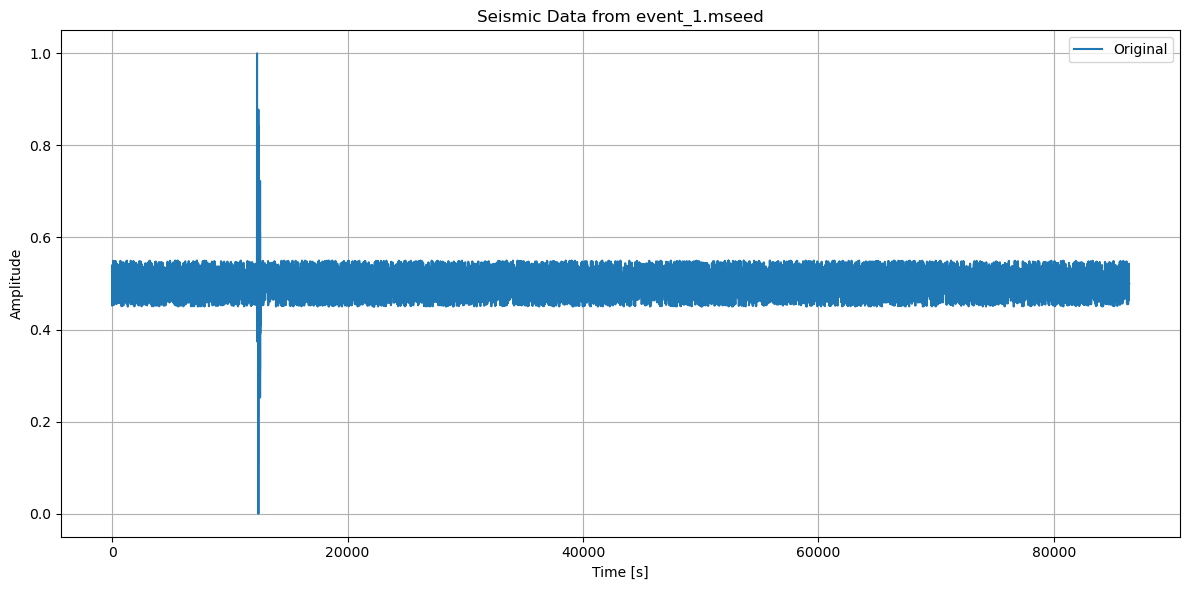

In [62]:
plot_file(r"D:\MO3 LAP\NASA 2024\padded\event_1.mseed")

In [4]:
def read_miniseed_files(files_directory):
    events = []
    
    for filename in os.listdir(files_directory):
        if filename.endswith(".mseed"):
            file_path = os.path.join(files_directory, filename)
            try:
                st = read(file_path)
                for trace in st:
                    events.append(trace)
                    print(f"Trace ID: {trace.id}")
                    print(f"Start Time: {trace.stats.starttime}")
                    print(f"End Time: {trace.stats.endtime}")
                    print(f"Number of Samples: {trace.stats.npts}")
                    print(f"Sampling Rate: {trace.stats.sampling_rate} Hz")
                    print(f"Data: {trace.data[:10]}...")  # Print first 10 data points for brevity
                    print('-' * 40)
            except Exception as e:
                print(f"An error occurred in file {filename}: {e}")
    
    return events
def apply_wavelet_transform(signal, wavelet='morl'):
    coeffs, freqs = pywt.cwt(signal, scales=np.arange(1, 256), wavelet=wavelet)
    return coeffs, freqs
# Function to plot time domain vs wavelet domain (scalogram) for multiple events
def plot_time_vs_wavelet(events, num_events=5, wavelet='morl'):
    random_events = random.sample(events, num_events)
    
    for i, trace in enumerate(random_events):
        signal = trace.data
        time = np.linspace(0, trace.stats.npts / trace.stats.sampling_rate, trace.stats.npts)
        
        # Apply wavelet transform
        coeffs, freqs = apply_wavelet_transform(signal, wavelet)
        
        # Plot Time Domain Signal
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(time, signal)
        plt.title(f"Event {i+1} - Time Domain")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        
        # Plot Wavelet Domain (Scalogram: Time-Frequency representation)
        plt.subplot(2, 1, 2)
        plt.imshow(np.abs(coeffs), extent=[0, time[-1], freqs.min(), freqs.max()], cmap='jet', aspect='auto', vmax=np.percentile(np.abs(coeffs), 99))
        plt.title(f"Event {i+1} - Wavelet Domain (Scalogram)")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hz)')
        
        plt.tight_layout()
        plt.show()
def extract_wavelet_features(signal, wavelet='morl'):
    # Perform the wavelet transform (CWT)
    coeffs, freqs = pywt.cwt(signal, scales=np.arange(1, 256), wavelet=wavelet)
    
    # Compute the energy of the wavelet coefficients
    energy = np.sum(np.abs(coeffs)**2)
    
    # Compute the entropy of the wavelet coefficients (Shannon entropy)
    prob_coeffs = np.abs(coeffs)**2 / np.sum(np.abs(coeffs)**2)
    entropy = -np.sum(prob_coeffs * np.log(prob_coeffs + 1e-12))  # Adding small epsilon to avoid log(0)
    
    # Find the dominant coefficient (max magnitude coefficient)
    dominant_coeff = np.max(np.abs(coeffs))
    
    # Find the frequency corresponding to the dominant coefficient
    dominant_scale_idx = np.argmax(np.max(np.abs(coeffs), axis=1))
    dominant_freq = freqs[dominant_scale_idx]
    
    # Compute other useful statistics like mean, variance, skewness, etc.
    mean_coeff = np.mean(coeffs)
    var_coeff = np.var(coeffs)
    
    # Create a feature dictionary
    features = {
        'energy': energy,
        'entropy': entropy,
        'dominant_coeff': dominant_coeff,
        'dominant_freq': dominant_freq,
        'mean_coeff': mean_coeff,
        'var_coeff': var_coeff
    }
    
    return features
        

In [ ]:
# Example path (use your specific path)
files_directory = r"D:\MO3 LAP\NASA 2024\Testing"

# Read MSEED data
events = read_miniseed_files(files_directory)

# Plot random 5 events: Time domain vs Wavelet domain (time-frequency)
plot_time_vs_wavelet(events, num_events=5, wavelet='morl')

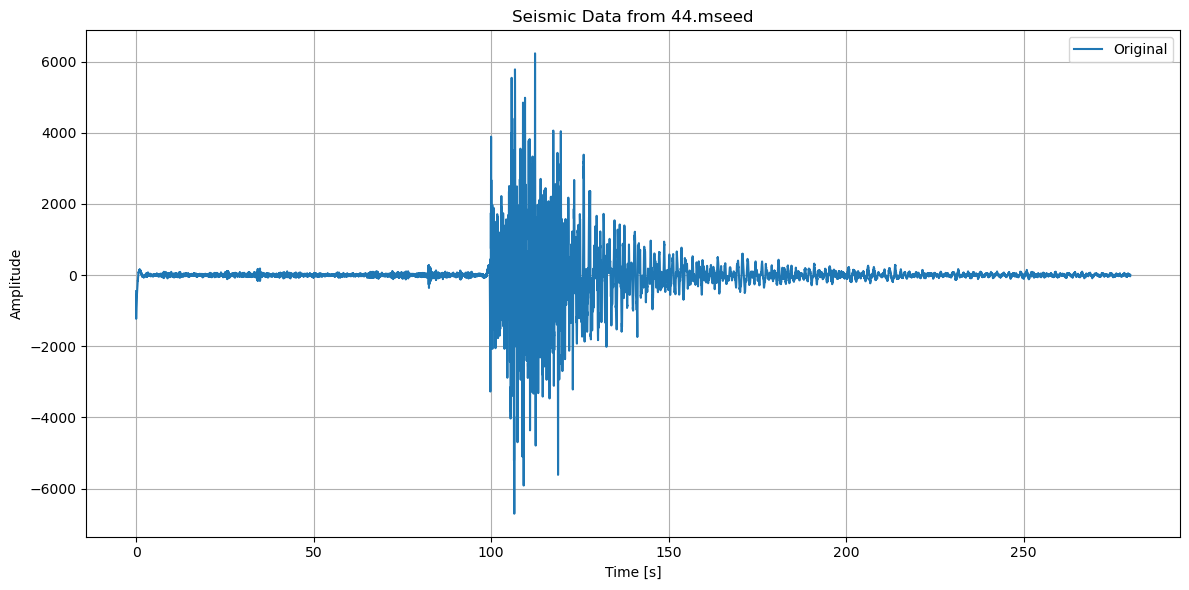

In [90]:
plot_file(r"D:\MO3 LAP\NASA 2024\BandedData-20241003T235810Z-001\BandedData\44.mseed")

In [4]:
normalize_file(r"d:\MO3 LAP\NASA 2024\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\data\S12_GradeA\xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed",save=True,output_directory=r"D:\MO3 LAP\NASA 2024\Testing\normalized output")

Normalized file saved as: D:\MO3 LAP\NASA 2024\Testing\normalized output\xa.s12.00.mhz.1970-01-19HR00_evid00002_normalized.mseed


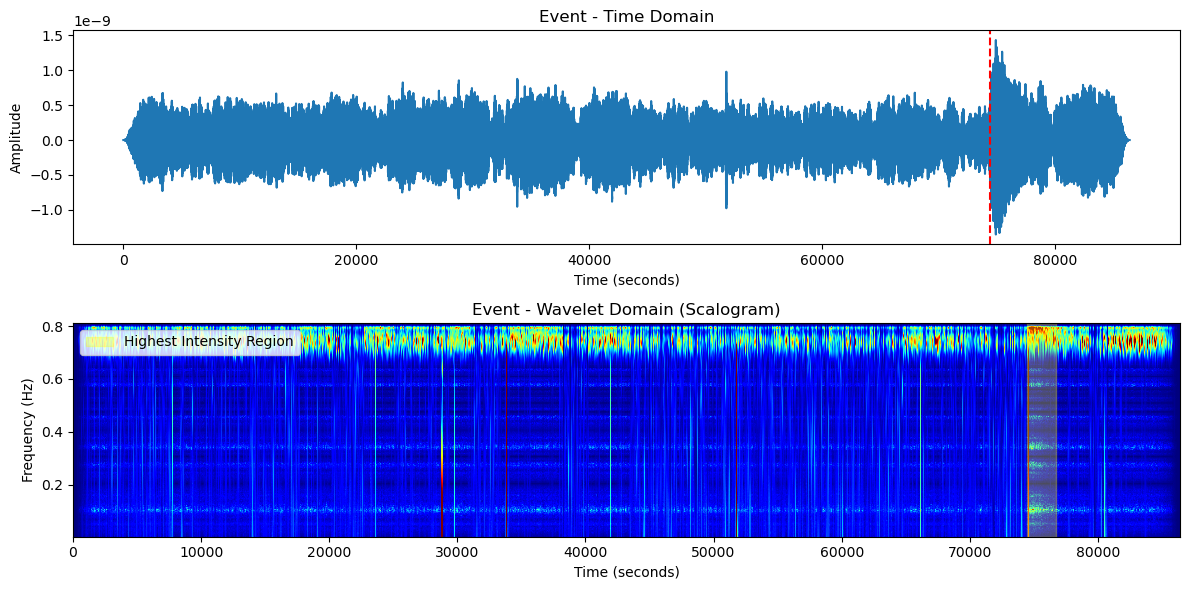

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you have your apply_wavelet_transform function available.

def plot_time_vs_wavelet_single_event(trace, wavelet='morl', window_size=15000, overlap=99):
    signal = trace.data
    time = np.linspace(0, trace.stats.npts / trace.stats.sampling_rate, trace.stats.npts)
    
    # Apply wavelet transform
    coeffs, freqs = apply_wavelet_transform(signal, wavelet)
    
    # Define overlapping windows in the time-frequency space
    num_windows = (len(time) - window_size) // overlap + 1
    max_weighted_amplitude = 0
    best_window = None
    
    # Define a weight function based on frequency
    def weight_function(frequencies):
        # Apply a linear weighting factor for frequencies above 0.7 Hz
        weights = np.where(frequencies > 0.7, frequencies, 0)  # Weighting is the frequency itself if above 0.7 Hz
        return weights

    for w in range(num_windows):
        # Define window range in time and frequency
        start_time = w * overlap
        end_time = start_time + window_size
        
        # Extract the window data from the coefficients (time axis)
        window_data = coeffs[:, start_time:end_time]  # Extract window slice
        
        # Apply the weight function to the frequencies
        weights = weight_function(freqs)
        
        # Calculate the weighted total amplitude for this window
        weighted_amplitude = np.sum(np.abs(window_data) * weights[:, np.newaxis])  # Sum of weighted absolute amplitudes
        
        # Find the window with the highest total amplitude
        if weighted_amplitude > max_weighted_amplitude:
            max_weighted_amplitude = weighted_amplitude
            best_window = (start_time, end_time)
    
    # Plot Time Domain Signal
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, signal)
    plt.title(f"Event - Time Domain")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    
    # Draw a red vertical line at the start of the best window
    if best_window:
        best_window_start_time = time[best_window[0]]
        plt.axvline(best_window_start_time, color='red', linestyle='--', label='Best Window Start')
    
    # Plot Wavelet Domain (Scalogram: Time-Frequency representation)
    plt.subplot(2, 1, 2)
    plt.imshow(np.abs(coeffs), extent=[0, time[-1], freqs.min(), freqs.max()], cmap='jet', aspect='auto', vmax=np.percentile(np.abs(coeffs), 99))
    plt.title(f"Event - Wavelet Domain (Scalogram)")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    
    # Highlight the best window on the scalogram plot
    if best_window:
        plt.axvspan(time[best_window[0]], time[best_window[1]], color='yellow', alpha=0.3, label='Highest Intensity Region')
        plt.legend()
    
    plt.tight_layout()
    plt.show()



# Call the function with your trace data
st = read(r"D:\MO3 LAP\NASA 2024\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\test\data\S16_GradeB\xa.s16.00.mhz.1974-11-14HR00_evid00587.mseed")
plot_time_vs_wavelet_single_event(st[0])


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
import pywt  # Ensure pywt is imported for wavelet transforms

def apply_wavelet_transform(signal, wavelet='morl'):
    coeffs, freqs = pywt.cwt(signal, scales=np.arange(1, 256), wavelet=wavelet)
    return coeffs, freqs

def process_mseed_directory(input_directory, output_directory, wavelet='morl', window_size=15000, overlap=99):
    for filename in os.listdir(input_directory):
        if filename.endswith('.mseed'):
            file_path = os.path.join(input_directory, filename)
            
            # Load the Miniseed file
            st = read(file_path)
            trace = st[0]  # Assuming you want to process the first trace
            
            # Apply bandpass filter
            Signal_read = trace.data  # Access the data from the Trace object
            Filtered_signal = trace.filter('bandpass', freqmin=0.5, freqmax=1, corners=4, zerophase=True).data
            Normalized_signal = (Filtered_signal - np.mean(Filtered_signal)) / np.std(Filtered_signal)
            
            # Apply wavelet transform
            coeffs, freqs = apply_wavelet_transform(Normalized_signal, wavelet)
            
            # Define overlapping windows in the time-frequency space
            num_windows = (len(Normalized_signal) - window_size) // overlap + 1
            max_weighted_amplitude = 0
            best_window = None
            
            # Define a weight function based on frequency
            def weight_function(frequencies):
                weights = np.where(frequencies > 0.7, frequencies, 0)
                return weights

            # Find the best window
            for w in range(num_windows):
                start_time = w * overlap
                end_time = start_time + window_size
                
                window_data = coeffs[:, start_time:end_time]
                weights = weight_function(freqs)
                
                weighted_amplitude = np.sum(np.abs(window_data) * weights[:, np.newaxis])
                
                if weighted_amplitude > max_weighted_amplitude:
                    max_weighted_amplitude = weighted_amplitude
                    best_window = (start_time, end_time)
            
            # Plotting only the Time Domain plot
            time = np.linspace(0, trace.stats.npts / trace.stats.sampling_rate, trace.stats.npts)
            plt.figure(figsize=(12, 6))
            plt.plot(time, Signal_read)
            plt.title(f"Event - Time Domain: {filename}")
            plt.xlabel('Time (seconds)')
            plt.ylabel('Amplitude')

            # Draw a red vertical line at the start of the best window
            if best_window:
                best_window_start_time = time[best_window[0]]
                plt.axvline(best_window_start_time, color='red', linestyle='--', label='Best Window Start')

            '''# Save the time domain plot with the red line
            plt.tight_layout()
            plot_filename = os.path.splitext(filename)[0] + '_Answer.png'
            plt.savefig(os.path.join(output_directory, plot_filename))
            plt.close()'''

            print(f"Processed {filename}: Best window starts at {best_window_start_time:.2f} seconds.")

# Directories
input_dir = r"D:\MO3 LAP\NASA 2024\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\test\data\S12_GradeB"
output_dir = r"D:\MO3 LAP\NASA 2024\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\test\data\S12_GradeB\S12_GradeB_plots"

# Process the Miniseed directory
process_mseed_directory(input_dir, output_dir)


Processed xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed: Best window starts at 1658.72 seconds.
Processed xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed: Best window starts at 7367.11 seconds.
Processed xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed: Best window starts at 11685.76 seconds.
Processed xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed: Best window starts at 44068.15 seconds.
Processed xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed: Best window starts at 82263.54 seconds.
Processed xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed: Best window starts at 63673.92 seconds.
Processed xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed: Best window starts at 38882.78 seconds.
Processed xa.s12.00.mhz.1970-05-20HR00_evid00026.mseed: Best window starts at 60490.97 seconds.
